## Reference

https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulelayers.py
https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py
https://github.com/XifengGuo/CapsNet-Keras/blob/master/utils.py

https://github.com/naturomics/CapsNet-Tensorflow/blob/master/capsLayer.py
https://github.com/naturomics/CapsNet-Tensorflow/blob/master/capsNet.py
https://github.com/naturomics/CapsNet-Tensorflow/blob/master/main.py

In [1]:
from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
from keras.utils import to_categorical
import numpy as np

## to_categorical

In [4]:
a = np.array([3, 5, 7])

In [5]:
to_categorical(a)

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [3]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    print("\noriginal size of x_train:", x_train.shape)
    print("original size of y_train:", y_train.shape)
    
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    
    print("translated size of x_train:", x_train.shape)
    print("translated size of y_train:", y_train.shape)
    
    return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist()


original size of x_train: (60000, 28, 28)
original size of y_train: (60000,)
translated size of x_train: (60000, 28, 28, 1)
translated size of y_train: (60000, 10)


In [10]:
print(x_train.shape[1:])

(28, 28, 1)


In [5]:
import tensorflow as tf
from keras import initializers, layers

## layers.Reshape

target_shape **doesn't** include the batch axis

In [16]:
a11 = layers.Input(shape=(12,))
print(a11.get_shape())

(?, 12)


In [21]:
a16 = layers.Reshape(target_shape=(-1, 3), input_shape=(12,))(a11) # input_shape doesn't include batch axis either
print(a16)
print(a16.get_shape())

Tensor("reshape_6/Reshape:0", shape=(?, 4, 3), dtype=float32)
(?, 4, 3)


## squash

In [6]:
def squash(vectors, axis = -1):
    s_squared_sum = K.sum(K.square(vectors), axis=axis, keepdims=True)
    scale = s_squared_sum / (1 + s_squared_sum) / K.sqrt(s_squared_sum + K.epsilon())
    return scale * vectors

In [23]:
a22 = np.random.rand(2, 5, 8)
print(a22.shape)

(2, 5, 8)


In [32]:
a23_1 = K.square(a22)
print("original shape: ", a23_1.shape)
a23_2 = K.sum(a23_1, axis = -1, keepdims=True)
print("shape with keepdims: ", a23_2.shape)
a23_3 = K.sum(a23_1, axis= -1)
print("shape without keepdims: ", a23_3.shape)

original shape:  (2, 5, 8)
shape with keepdims:  (2, 5, 1)
shape without keepdims:  (2, 5)


In [7]:
def PrimaryCapsule(inputs, dim_capsule, num_channels, kernel_size, strides, padding):
    output = layers.Conv2D(filters = dim_capsule * num_channels, kernel_size = kernel_size,
                          strides = strides, padding=padding, name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [8]:
input_shape = x_train.shape[1:]
print("input shape: ", input_shape)

input shape:  (28, 28, 1)


In [9]:
n_class = len(np.unique(np.argmax(y_train, 1)))
print("class number: ", n_class)

class number:  10


## hyper parameters

In [10]:
# number of iterations used in routing algorithm.
routings = 3
learning_rate = 0.001
batch_size = 100
epochs = 10
learning_rate_decay = 0.9
lam_recon = 0.392
save_dir = './capnet_result'

## Create Model

In [11]:
x = layers.Input(shape=input_shape)
print(x.get_shape())

(?, 28, 28, 1)


In [12]:
# Layer 1: Conv2D layer
conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)
print(conv1.get_shape())

(?, 20, 20, 256)


In [13]:
# layer 2: primary capsule layer (conv2d layer)
primarycaps = PrimaryCapsule(conv1, dim_capsule=8, num_channels=32, kernel_size=9, strides=2, padding='valid')
print(primarycaps.get_shape())

(?, 1152, 8)


### Create Capsule layer

### Dynamic routing algorithm

## Utility layers

In [14]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [15]:
class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

In [16]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

In [17]:
digitCaps = CapsuleLayer(num_capsule = n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

In [18]:
print(digitCaps.get_shape())

(?, 10, 16)


In [19]:
out_caps = Length(name='capsnet')(digitCaps)
print('output capsule length shape: ', out_caps.get_shape())

output capsule length shape:  (?, 10)


### decoder network

In [20]:
y = layers.Input(shape=(n_class,)) # the true label
masked_by_y = Mask()([digitCaps, y]) # for training
masked = Mask()(digitCaps) # Mask using the capsule with maximal length. For prediction
print('masked y shape: ', masked.get_shape(), masked_by_y.get_shape())

masked y shape:  (?, ?) (?, ?)


In [21]:
from keras import models, optimizers
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(512, activation='relu', input_dim = 16 * n_class))
decoder.add(layers.Dense(1024, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

In [22]:
train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
eval_model = models.Model(x, [out_caps, decoder(masked)])

In [23]:
# manipulate model
noise = layers.Input(shape=(n_class, 16))
noised_digitcaps = layers.Add()([digitCaps, noise])
masked_noised_y = Mask()([digitCaps, y])
manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))

In [24]:
train_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 20, 20, 256)   20992       input_1[0][0]                    
____________________________________________________________________________________________________
primarycap_conv2d (Conv2D)       (None, 6, 6, 256)     5308672     conv1[0][0]                      
____________________________________________________________________________________________________
primarycap_reshape (Reshape)     (None, 1152, 8)       0           primarycap_conv2d[0][0]          
___________________________________________________________________________________________

In [25]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

## Train model

In [26]:
from keras import callbacks
log = callbacks.CSVLogger(save_dir + '/log.csv')

In [27]:
tb = callbacks.TensorBoard(save_dir + '/tensorboard-logs', batch_size=batch_size)

In [28]:
checkpoint = callbacks.ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_cc', 
                                       save_best_only=True, save_weights_only=True, verbose=1)

In [29]:
lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch : learning_rate * (learning_rate_decay ** epoch))

In [30]:
train_model.compile(optimizer = optimizers.Adam(lr=learning_rate),
                   loss =[margin_loss, 'mse'],
                   loss_weights = [1.0, lam_recon],
                   metrics= {'capsnet': 'accuracy'})

In [31]:
train_model.fit([x_train, y_train], [y_train, x_train], batch_size=batch_size, epochs=epochs,
                validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])

train_model.save_weights(save_dir + '/trained_model.h5')
print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3023s - loss: 0.0837 - capsnet_loss: 0.0621 - decoder_loss: 0.0553 - capsnet_acc: 0.9430 - val_loss: 0.0354 - val_capsnet_loss: 0.0187 - val_decoder_loss: 0.0427 - val_capsnet_acc: 0.9873

C:\Users\shuhua\AppData\Local\Continuum\anaconda3\envs\tensorflow-env\lib\site-packages\keras\callbacks.py:405: RuntimeWarning: Can save best model only with val_capsnet_cc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/10
60000/60000 [==============================] - 3010s - loss: 0.0309 - capsnet_loss: 0.0159 - decoder_loss: 0.0383 - capsnet_acc: 0.9892 - val_loss: 0.0297 - val_capsnet_loss: 0.0159 - val_decoder_loss: 0.0350 - val_capsnet_acc: 0.9890
Epoch 3/10
60000/60000 [==============================] - 3015s - loss: 0.0237 - capsnet_loss: 0.0108 - decoder_loss: 0.0330 - capsnet_acc: 0.9925 - val_loss: 0.0218 - val_capsnet_loss: 0.0096 - val_decoder_loss: 0.0309 - val_capsnet_acc: 0.9921
Epoch 4/10
60000/60000 [==============================] - 3012s - loss: 0.0196 - capsnet_loss: 0.0080 - decoder_loss: 0.0296 - capsnet_acc: 0.9948 - val_loss: 0.0221 - val_capsnet_loss: 0.0111 - val_decoder_loss: 0.0279 - val_capsnet_acc: 0.9896
Epoch 5/10
60000/60000 [==============================] - 3009s - loss: 0.0160 - capsnet_loss: 0.0056 - decoder_loss: 0.0267 - capsnet_acc: 0.9967 - val_loss: 0.0180 - val_capsnet_loss: 0.0081 - val_decoder_loss: 0.0254 - val_capsnet_acc: 0.9925
Epoch 6/10
6000

In [36]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline

def plot_log(filename, show=True):
    # load data
    keys = []
    values = []
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if keys == []:
                for key, value in row.items():
                    keys.append(key)
                    values.append(float(value))
                continue

            for _, value in row.items():
                values.append(float(value))

        values = np.reshape(values, newshape=(-1, len(keys)))
        values[:,0] += 1

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for i, key in enumerate(keys):
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(values[:, 0], values[:, i], label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for i, key in enumerate(keys):
        if key.find('acc') >= 0:  # acc
            plt.plot(values[:, 0], values[:, i], label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()

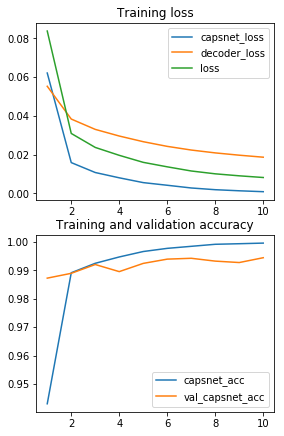

In [37]:
plot_log(save_dir + '/log.csv', show=True)

## Manipulate latent

In [41]:
manipulate_digit = 8
index = np.argmax(y_test, 1) == manipulate_digit
print(index.shape)
print(index[0])
print('sum(index): ', sum(index))

(10000,)
False
sum(index):  974


In [42]:
number = np.random.randint(low=0, high=sum(index) -1)
print(number)

150


In [44]:
manipulate_x, manipulate_y = x_test[index][number], y_test[index][number]
print(manipulate_x.shape, manipulate_y.shape)
print(manipulate_y)

(28, 28, 1) (10,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [45]:
b_manipulate_x, b_manipulate_y = np.expand_dims(manipulate_x, 0), np.expand_dims(manipulate_y, 0)
print(b_manipulate_x.shape, b_manipulate_y.shape)

(1, 28, 28, 1) (1, 10)


In [46]:
import math
def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [47]:
manipulate_noise = np.zeros([1, 10, 16])
x_recons = []
for dim in range(16):
    for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(manipulate_noise)
            tmp[:,:,dim] = r
            x_recon = manipulate_model.predict([b_manipulate_x, b_manipulate_y, tmp])
            x_recons.append(x_recon)
            
print(x_recons[0].shape)

(1, 28, 28, 1)


In [48]:
x_recons = np.concatenate(x_recons)
print(x_recons.shape)

(176, 28, 28, 1)


In [51]:
from PIL import Image
img = combine_images(x_recons, height=16)
constructed_img = img * 255
Image.fromarray(constructed_img.astype(np.uint8)).save(save_dir + '/manipulate-%d.png' % manipulate_digit)
print('manipulated result saved to %s/manipulate-%d.png' % (save_dir, manipulate_digit))

manipulated result saved to ./capnet_result/manipulate-8.png


<function matplotlib.pyplot.show>

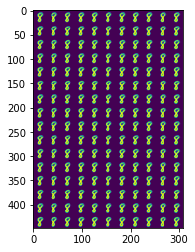

In [53]:
from matplotlib import pyplot as plt
plt.imshow(constructed_img.astype(np.uint8))
plt.show

## Test

In [55]:
test_y_pred, test_x_recon = eval_model.predict(x_test, batch_size=100)

In [56]:
print('Test accuracy: ', np.sum(np.argmax(test_y_pred, 1) == np.argmax(y_test, 1))/x_test.shape[0])

Test accuracy:  0.9945


In [57]:
test_img = combine_images(np.concatenate([x_test[:50], test_x_recon[:50]]))
test_img_scale = test_img * 255
Image.fromarray(test_img_scale.astype(np.uint8)).save(save_dir +"/real_and_recon.png")

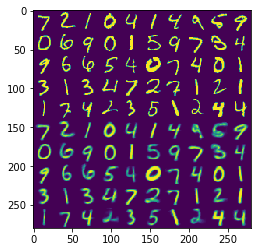

In [58]:
plt.imshow(plt.imread(save_dir +"/real_and_recon.png"))
plt.show()